# Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

- Критерии оценки проекта «Промышленность»

    Целевой признак: последняя измеренная температура.

    Метрика: MAE

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## 1. Загрузка данных и исследовательский анализ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import numpy as np

* **Изучим данные об электродах**

In [2]:
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [3]:
df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Есть аномалия: мощность отрицательная. Это смена технологического процесса. На нагрев не идёт. Убираем. Посмотрим, сколько значений с отрицательной мощностью:

In [4]:
(df_arc['Реактивная мощность'] < 0).sum()

1

Всего одна строчка с отрицательной мощностью! Предлагаю её найти:

In [5]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


...и удалить:

In [6]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

Проверим, если ли пропуски в датасете с электродами:

In [7]:
df_arc.isnull().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропусков нет

Проверим, есть ли дубликаты: 

In [8]:
df_arc.duplicated().sum()

0

Дубликатов нет. Исследуем на выбросы:

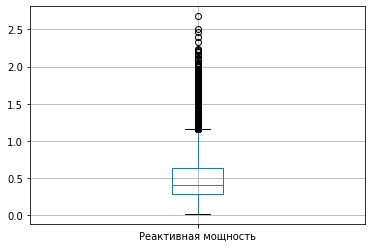

In [9]:
df_arc.boxplot(column = 'Реактивная мощность')

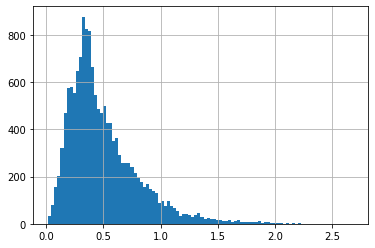

In [10]:
df_arc['Реактивная мощность'].hist(bins=100)

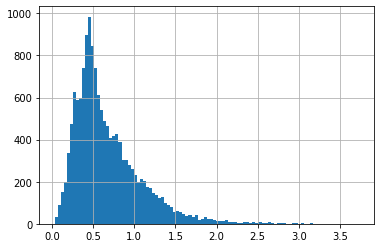

In [11]:
df_arc['Активная мощность'].hist(bins=100)

Глядя на гистограммы видно, что распределение мощностей скошены вправо.

* **Изучим данные о подаче сыпучих материалов (объём)**

In [12]:
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbaefc2c50>,
      dtype=object)

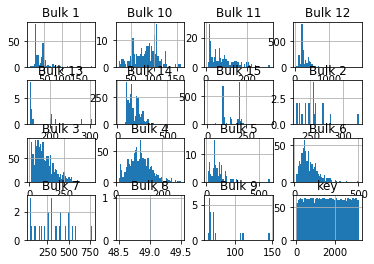

In [13]:
df_bulk.hist(bins=50)

* **Изучим данные о подаче сыпучих материалов (время)**

In [14]:
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


* **Изучим данные о продувке сплава газом**

In [15]:
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


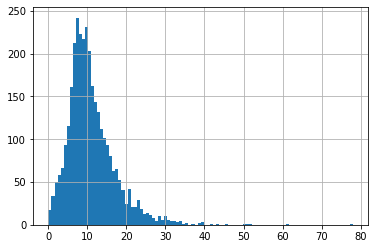

In [16]:
df_gas['Газ 1'].hist(bins=100)

Проверим на пропуски:

In [17]:
df_gas.isnull().sum()

key      0
Газ 1    0
dtype: int64

* **данные о проволочных материалах (объём):**

In [18]:
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **данные о проволочных материалах (время):**

In [19]:
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
df_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **Изучим результаты измерения температуры**

In [20]:
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Взглянем на гистограмму и диаграмму размаха:

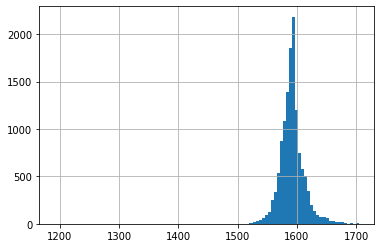

In [21]:
df_temp['Температура'].hist(bins=100)

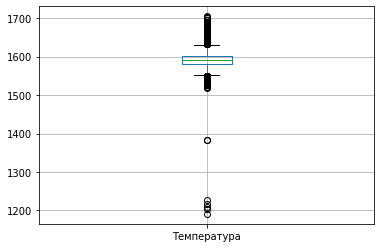

In [22]:
df_temp.boxplot(column='Температура')

In [23]:
df_temp.isnull().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Очень много пропусков температуры. 

Сгруппируем данные и посмотрим количество замеров температуры в каждой партии:

In [24]:
temp_count = df_temp.groupby('key').agg({'Температура': 'count'})
#temp_count.value_counts()

In [25]:
temp_count.rename({'Температура': 'count_mesure'}, axis=1, inplace=True)
temp_count

,count_mesure
key,
1,5
2,6
3,5
4,3
5,2
...,...
3237,1
3238,1
3239,1


In [26]:
temp_max = df_temp.groupby('key').agg({'Температура': 'last'})
temp_max.rename({'Температура': 'temp_end'}, axis=1, inplace=True)
temp_max

,temp_end
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0
...,...
3237,1569.0
3238,1584.0
3239,1598.0


In [27]:
temp_min = df_temp.groupby('key').agg({'Температура': 'first'})
temp_min.rename({'Температура': 'temp_start'}, axis=1, inplace=True)
temp_min

,temp_start
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0
...,...
3237,1569.0
3238,1584.0
3239,1598.0


## 2. Создание сводной таблицы

Создадим сводную таблицу по данным замера температуры:

In [28]:
temp = temp_count

In [29]:
temp['temp_start'] = temp_min['temp_start']
temp['temp_end'] = temp_max['temp_end']
temp.head()

,count_mesure,temp_start,temp_end
key,,,
1,5,1571.0,1613.0
2,6,1581.0,1602.0
3,5,1596.0,1599.0
4,3,1601.0,1625.0
5,2,1576.0,1602.0


Создадим сводную таблицу по данным об электродах:

In [30]:
df_arc = pd.read_csv('/datasets/final_steel//data_arc.csv', 
                     parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])

Измерим время нагрева:

In [31]:
df_arc['time'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28


In [32]:
arc_time = df_arc.groupby('key').agg({'time': 'sum'})
arc_time.rename({'time': 'arc_time'}, axis=1, inplace=True)
arc_time.head()

,arc_time
key,
1,00:18:18
2,00:13:31
3,00:10:55
4,00:12:21
5,00:14:29


Нам понадобится таблица с суммой мощностей по каждой партии:

In [33]:
arc_power_act = df_arc.groupby('key').agg({'Активная мощность': 'sum'})
arc_power_act.rename({'Активная мощность': 'act_power'}, axis=1, inplace=True)
arc_power_act.head()

,act_power
key,
1,4.878147
2,3.052598
3,2.525882
4,3.209250
5,3.347173


In [34]:
arc_power_react = df_arc.groupby('key').agg({'Реактивная мощность': 'sum'})
arc_power_react.rename({'Реактивная мощность': 'react_power'}, axis=1, inplace=True)
arc_power_react.head()

,react_power
key,
1,3.183241
2,1.998112
3,1.599076
4,2.060298
5,2.252643


In [35]:
power = arc_power_act
power['react_power'] = arc_power_react['react_power']
power['time_heat'] = arc_time['arc_time']
power.head()

,act_power,react_power,time_heat
key,,,
1,4.878147,3.183241,00:18:18
2,3.052598,1.998112,00:13:31
3,2.525882,1.599076,00:10:55
4,3.209250,2.060298,00:12:21
5,3.347173,2.252643,00:14:29


Последовательно соеденим таблицы:

In [36]:
data = temp.merge(power, on='key', how='left')
data

,count_mesure,temp_start,temp_end,act_power,react_power,time_heat
key,,,,,,
1,5,1571.0,1613.0,4.878147,3.183241,00:18:18
2,6,1581.0,1602.0,3.052598,1.998112,00:13:31
3,5,1596.0,1599.0,2.525882,1.599076,00:10:55
4,3,1601.0,1625.0,3.209250,2.060298,00:12:21
5,2,1576.0,1602.0,3.347173,2.252643,00:14:29
...,...,...,...,...,...,...
3237,1,1569.0,1569.0,3.932467,2.828459,00:15:09
3238,1,1584.0,1584.0,2.106529,1.681182,00:09:06
3239,1,1598.0,1598.0,4.666754,3.111617,00:20:16


In [37]:
data = data.merge(df_gas, on='key', how='left')
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1
0,1,5,1571.0,1613.0,4.878147,3.183241,00:18:18,29.749986
1,2,6,1581.0,1602.0,3.052598,1.998112,00:13:31,12.555561
2,3,5,1596.0,1599.0,2.525882,1.599076,00:10:55,28.554793
3,4,3,1601.0,1625.0,3.209250,2.060298,00:12:21,18.841219
4,5,2,1576.0,1602.0,3.347173,2.252643,00:14:29,5.413692
...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,00:15:09,5.543905
3212,3238,1,1584.0,1584.0,2.106529,1.681182,00:09:06,6.745669
3213,3239,1,1598.0,1598.0,4.666754,3.111617,00:20:16,16.023518
3214,3240,1,1617.0,1617.0,2.984083,2.483267,00:13:59,11.863103


In [38]:
data = data.merge(df_bulk, on='key', how='left')
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,5,1571.0,1613.0,4.878147,3.183241,00:18:18,29.749986,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,6,1581.0,1602.0,3.052598,1.998112,00:13:31,12.555561,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,5,1596.0,1599.0,2.525882,1.599076,00:10:55,28.554793,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,3,1601.0,1625.0,3.209250,2.060298,00:12:21,18.841219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,2,1576.0,1602.0,3.347173,2.252643,00:14:29,5.413692,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,00:15:09,5.543905,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3212,3238,1,1584.0,1584.0,2.106529,1.681182,00:09:06,6.745669,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3213,3239,1,1598.0,1598.0,4.666754,3.111617,00:20:16,16.023518,NaN,NaN,...,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3214,3240,1,1617.0,1617.0,2.984083,2.483267,00:13:59,11.863103,NaN,NaN,...,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [39]:
data = data.merge(df_wire, on='key', how='left')
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,4.878147,3.183241,00:18:18,29.749986,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6,1581.0,1602.0,3.052598,1.998112,00:13:31,12.555561,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5,1596.0,1599.0,2.525882,1.599076,00:10:55,28.554793,NaN,NaN,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,1601.0,1625.0,3.209250,2.060298,00:12:21,18.841219,NaN,NaN,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,1576.0,1602.0,3.347173,2.252643,00:14:29,5.413692,NaN,NaN,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,00:15:09,5.543905,NaN,NaN,...,206.0,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3212,3238,1,1584.0,1584.0,2.106529,1.681182,00:09:06,6.745669,NaN,NaN,...,106.0,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,3239,1,1598.0,1598.0,4.666754,3.111617,00:20:16,16.023518,NaN,NaN,...,88.0,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,3240,1,1617.0,1617.0,2.984083,2.483267,00:13:59,11.863103,NaN,NaN,...,54.0,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Извлечём в качестве признаков из времени нагрева минуты и секунды:

In [40]:
data['time_heat'] = data['time_heat'].dt.total_seconds()
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,4.878147,3.183241,1098.0,29.749986,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,6,1581.0,1602.0,3.052598,1.998112,811.0,12.555561,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5,1596.0,1599.0,2.525882,1.599076,655.0,28.554793,NaN,NaN,...,153.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3,1601.0,1625.0,3.209250,2.060298,741.0,18.841219,NaN,NaN,...,154.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,1576.0,1602.0,3.347173,2.252643,869.0,5.413692,NaN,NaN,...,152.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,909.0,5.543905,NaN,NaN,...,206.0,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3212,3238,1,1584.0,1584.0,2.106529,1.681182,546.0,6.745669,NaN,NaN,...,106.0,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,3239,1,1598.0,1598.0,4.666754,3.111617,1216.0,16.023518,NaN,NaN,...,88.0,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,3240,1,1617.0,1617.0,2.984083,2.483267,839.0,11.863103,NaN,NaN,...,54.0,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NaN'ы - это отсутствие добавления газа/примесей. Поэтому смело заменим нулями:

In [41]:
data = data.fillna(0)
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,1571.0,1613.0,4.878147,3.183241,1098.0,29.749986,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,3.052598,1.998112,811.0,12.555561,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,2.525882,1.599076,655.0,28.554793,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,3.209250,2.060298,741.0,18.841219,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,3.347173,2.252643,869.0,5.413692,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,909.0,5.543905,0.0,0.0,...,206.0,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3212,3238,1,1584.0,1584.0,2.106529,1.681182,546.0,6.745669,0.0,0.0,...,106.0,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3213,3239,1,1598.0,1598.0,4.666754,3.111617,1216.0,16.023518,0.0,0.0,...,88.0,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3214,3240,1,1617.0,1617.0,2.984083,2.483267,839.0,11.863103,0.0,0.0,...,54.0,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавим сумму квадратов мощностей как признак:

In [42]:
data['sqr_power'] = data['act_power']*data['act_power'] + data['react_power']*data['react_power']
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sqr_power
0,1,5,1571.0,1613.0,4.878147,3.183241,1098.0,29.749986,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.929337
1,2,6,1581.0,1602.0,3.052598,1.998112,811.0,12.555561,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.310806
2,3,5,1596.0,1599.0,2.525882,1.599076,655.0,28.554793,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.937125
3,4,3,1601.0,1625.0,3.209250,2.060298,741.0,18.841219,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.544113
4,5,2,1576.0,1602.0,3.347173,2.252643,869.0,5.413692,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.277964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3237,1,1569.0,1569.0,3.932467,2.828459,909.0,5.543905,0.0,0.0,...,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.464476
3212,3238,1,1584.0,1584.0,2.106529,1.681182,546.0,6.745669,0.0,0.0,...,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.263837
3213,3239,1,1598.0,1598.0,4.666754,3.111617,1216.0,16.023518,0.0,0.0,...,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.460758
3214,3240,1,1617.0,1617.0,2.984083,2.483267,839.0,11.863103,0.0,0.0,...,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.071366


**data** - готовая сводная таблица, чтобы её делить на признаки

## 3. Деление сводной таблицы на обучающую, валидационную и тестовую выборки

По рекомендациям тимлида удалим те партии, где только один замер температуры перед делением на выборки:

In [43]:
data = data.query('count_mesure > 1')
data

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sqr_power
0,1,5,1571.0,1613.0,4.878147,3.183241,1098.0,29.749986,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.929337
1,2,6,1581.0,1602.0,3.052598,1.998112,811.0,12.555561,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.310806
2,3,5,1596.0,1599.0,2.525882,1.599076,655.0,28.554793,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.937125
3,4,3,1601.0,1625.0,3.209250,2.060298,741.0,18.841219,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.544113
4,5,2,1576.0,1602.0,3.347173,2.252643,869.0,5.413692,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.277964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,3,1570.0,1591.0,3.210690,2.360777,723.0,7.125735,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.881798
2473,2496,4,1554.0,1591.0,4.203064,2.810185,940.0,9.412616,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.562890
2474,2497,2,1571.0,1589.0,2.212379,1.851269,569.0,6.271699,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.321818
2475,2498,5,1591.0,1594.0,3.408725,2.355428,750.0,14.953657,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.167451


In [44]:
data.corr()[data.corr() > 0.8]

,key,count_mesure,temp_start,temp_end,act_power,react_power,time_heat,Газ 1,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sqr_power
key,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count_mesure,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp_start,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp_end,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
act_power,NaN,NaN,NaN,NaN,1.000000,NaN,0.978183,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
react_power,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_heat,NaN,NaN,NaN,NaN,0.978183,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Газ 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобъём выборки:

In [45]:
data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=12345) 

In [46]:
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345) 

In [47]:
import re

In [48]:
data_train = data_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data_valid = data_valid.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data_test = data_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## 4. Предобработка данных на обучающей выборке

Необходимо убрать выбросы по температуре, так как там есть аномальные значения (по логике ясно, что температура не модет быть ниже 1400: температуры плавления стали):

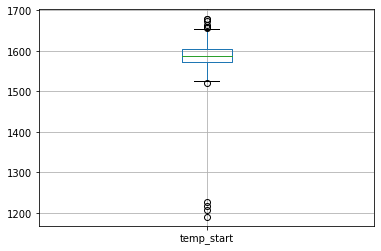

In [49]:
data_train.boxplot(column = 'temp_start')

In [50]:
data_train.shape

(1485, 33)

In [51]:
data_train = data_train.query('temp_start > 1400')

In [52]:
data_train.shape

(1481, 33)

Зададим признаки для обучения и целевой признак. Целевой признак - это конечный замер температуры:

In [53]:
features_train = data_train.drop(['temp_end','key','time_heat'], axis=1)
target_train = data_train['temp_end']
features_valid = data_valid.drop(['temp_end','key','time_heat'], axis=1)
target_valid = data_valid['temp_end']

In [54]:
features_test = data_test.drop(['temp_end','key','time_heat'], axis=1)
target_test = data_test['temp_end']

## 5. Обучение моделей

In [55]:
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions_LR = model_LR.predict(features_valid)
mae = mean_absolute_error(target_valid, predictions_LR)
mae

7.475506951080495

In [56]:
for depth in range(1, 20):
    model_TreeReg = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_TreeReg.fit(features_train, target_train) 
    predictions_TreeReg = model_TreeReg.predict(features_valid)
    mae_Tree = mean_absolute_error(target_valid, predictions_TreeReg) 
    print(mae_Tree)

9.004485116124576
8.390409425930818
8.261012418834122
7.91388425194689
7.772343112722019
7.629259235552132
7.493066990676012
7.656300209929006
7.622120003191725
7.925674537339486
8.331391940421236
8.4027308585828
8.56373571075598
8.777907079029339
8.86234136695964
8.979119844054104
9.099135559394963
8.954850768300325
8.993162936219589


In [57]:
for est in range(1, 41):
    model_RFReg = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=60)
    model_RFReg.fit(features_train, target_train)
    predictions_RFReg = model_RFReg.predict(features_valid)
    mae_RFReg = mean_absolute_error(target_valid, predictions_RFReg) 
    print(mae_RFReg)

9.214141414141414
7.973737373737373
7.511784511784513
7.1282828282828286
7.105454545454544
6.944107744107743
6.896681096681093
6.88989898989899
6.7795735129068495
6.734747474747475
6.663728191000914
6.5442760942760945
6.5387723387723415
6.521645021645025
6.514074074074073
6.534974747474747
6.520617944147351
6.478675645342314
6.46900584795322
6.48828282828283
6.462337662337664
6.475298438934809
6.454457619675012
6.4541245791245805
6.433696969696968
6.445221445221447
6.446838757949873
6.435353535353538
6.41894810170673
6.383367003366999
6.379406972955358
6.3642045454545455
6.374104683195592
6.37147950089127
6.333910533910533
6.32474747474748
6.333497133497129
6.333971291866028
6.339756539756534
6.330353535353533


In [58]:
for num in range(2, 31):
    model_light = LGBMRegressor(random_state=12345, num_leaves = num)
    model_light.fit(features_train, target_train, verbose=True)
    predictions_light = model_light.predict(features_valid)
    mae_light = mean_absolute_error(target_valid, predictions_light)
    print(mae_light)

7.4023090808290215
6.397681353067582
6.231695470920251
6.173968422551951
6.175128541185024
6.154151751579275
6.122265434760959
6.072195773229401
6.101395998172161
6.11483584167332
6.124769954449119
6.174635465020929
6.103912356546144
6.180062236199988
6.171047214423235
6.172511537468449
6.070889017085114
6.1053088334977925
6.176099518673845
6.166101370809837
6.255039845637165
6.129512804381186
6.184687705045955
6.118186687746964
6.173734842222853
6.156835240175057
6.189304804890897
6.166177751221798
6.1213972852323835


In [59]:
model_cat = CatBoostRegressor()
model_cat.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_valid)
mae_cat = mean_absolute_error(target_valid, predictions_cat)

0:	learn: 15.6106359	total: 49.5ms	remaining: 49.4s
1:	learn: 15.3793952	total: 51.4ms	remaining: 25.6s
2:	learn: 15.1563369	total: 53.3ms	remaining: 17.7s
3:	learn: 14.9466128	total: 55.2ms	remaining: 13.8s
4:	learn: 14.7557074	total: 62.9ms	remaining: 12.5s
5:	learn: 14.5586559	total: 115ms	remaining: 19s
6:	learn: 14.3616137	total: 117ms	remaining: 16.6s
7:	learn: 14.1823994	total: 119ms	remaining: 14.7s
8:	learn: 13.9860787	total: 121ms	remaining: 13.3s
9:	learn: 13.7939365	total: 122ms	remaining: 12.1s
10:	learn: 13.6240619	total: 124ms	remaining: 11.2s
11:	learn: 13.4571139	total: 212ms	remaining: 17.5s
12:	learn: 13.3012479	total: 214ms	remaining: 16.3s
13:	learn: 13.1561907	total: 216ms	remaining: 15.2s
14:	learn: 13.0083476	total: 218ms	remaining: 14.3s
15:	learn: 12.8644951	total: 220ms	remaining: 13.5s
16:	learn: 12.7086437	total: 310ms	remaining: 17.9s
17:	learn: 12.5680846	total: 313ms	remaining: 17.1s
18:	learn: 12.4343217	total: 315ms	remaining: 16.3s
19:	learn: 12.31783

In [60]:
mae_cat

5.937320221481473

In [61]:
feature_names = np.array(features_train.columns)
feature_importance = np.array(model_cat.get_feature_importance())
data={'feature_names':feature_names,'feature_importance':feature_importance}
data = pd.DataFrame(data)
data = data.sort_values(by = 'feature_importance', ascending = False)
print(data)

   feature_names  feature_importance
1     temp_start           30.762197
20         Wire1           24.669687
2      act_power           10.858416
3    react_power            4.695115
29     sqr_power            4.357388
4              1            3.239995
18        Bulk14            2.586259
21         Wire2            2.452686
10         Bulk6            2.444425
16        Bulk12            2.110942
5          Bulk1            2.012501
0   count_mesure            1.998704
19        Bulk15            1.916660
8          Bulk4            1.643425
7          Bulk3            1.106276
11         Bulk7            0.789304
15        Bulk11            0.433866
23         Wire4            0.418466
25         Wire6            0.411124
9          Bulk5            0.344706
14        Bulk10            0.280383
6          Bulk2            0.150259
17        Bulk13            0.126340
26         Wire7            0.118504
22         Wire3            0.030748
27         Wire8            0.030243
1

<function matplotlib.pyplot.show(*args, **kw)>

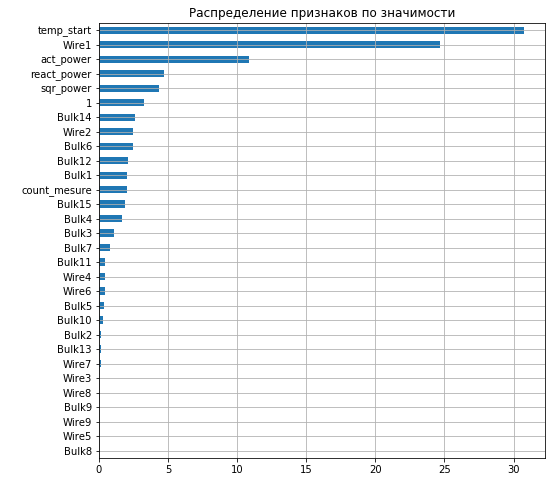

In [62]:
data.plot(x = 'feature_names' , y='feature_importance', kind='barh', grid=True, legend=None, figsize=(8, 8)).invert_yaxis()
plt.title('Распределение признаков по значимости', fontsize=12)
plt.ylabel(" ")
plt.xlabel(" ")
plt.show

## 6. Тестирование моделей

In [63]:
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions_LR = model_LR.predict(features_test)
mae = mean_absolute_error(target_test, predictions_LR)
mae

7.772009190113158

In [64]:
model_TreeReg = DecisionTreeRegressor(random_state=12345, max_depth=6)
model_TreeReg.fit(features_train, target_train) 
predictions_TreeReg = model_TreeReg.predict(features_test)
mae_Tree = mean_absolute_error(target_test, predictions_TreeReg) 
mae_Tree

7.4107282900671105

In [65]:
model_RFReg = RandomForestRegressor(random_state=12345, n_estimators=121, max_depth=60)
model_RFReg.fit(features_train, target_train)
predictions_RFReg = model_RFReg.predict(features_test)
mae = mean_absolute_error(target_test, predictions_RFReg)
mae

6.4806411219634406

In [66]:
model_light = LGBMRegressor(num_leaves = 11)
model_light.fit(features_train, target_train, verbose=True)
predictions_light = model_light.predict(features_test)
mae_light = mean_absolute_error(target_test, predictions_light)
mae_light

6.348266935275963

In [67]:
model_cat = CatBoostRegressor()
model_cat.fit(features_train, target_train)
predictions_cat = model_cat.predict(features_test)
mae_cat = mean_absolute_error(target_test, predictions_cat)

0:	learn: 15.6106359	total: 2.31ms	remaining: 2.31s
1:	learn: 15.3793952	total: 4.49ms	remaining: 2.24s
2:	learn: 15.1563369	total: 6.48ms	remaining: 2.15s
3:	learn: 14.9466128	total: 8.4ms	remaining: 2.09s
4:	learn: 14.7557074	total: 11ms	remaining: 2.19s
5:	learn: 14.5586559	total: 13.1ms	remaining: 2.17s
6:	learn: 14.3616137	total: 20.6ms	remaining: 2.92s
7:	learn: 14.1823994	total: 101ms	remaining: 12.6s
8:	learn: 13.9860787	total: 104ms	remaining: 11.4s
9:	learn: 13.7939365	total: 105ms	remaining: 10.4s
10:	learn: 13.6240619	total: 107ms	remaining: 9.64s
11:	learn: 13.4571139	total: 115ms	remaining: 9.44s
12:	learn: 13.3012479	total: 201ms	remaining: 15.3s
13:	learn: 13.1561907	total: 203ms	remaining: 14.3s
14:	learn: 13.0083476	total: 206ms	remaining: 13.5s
15:	learn: 12.8644951	total: 208ms	remaining: 12.8s
16:	learn: 12.7086437	total: 215ms	remaining: 12.4s
17:	learn: 12.5680846	total: 297ms	remaining: 16.2s
18:	learn: 12.4343217	total: 299ms	remaining: 15.5s
19:	learn: 12.3178

In [68]:
mae_cat

6.2406118707569735

**ВЫВОД:** 
* Модель **градиентный бустинг (cat_boost)** даёт значение **MAE: 6.24**.